<a href="https://colab.research.google.com/github/StoneMason495/cap-comp215/blob/main/215Project2ZM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Daisy World: Testing the Gaia Hypothesis
###By: Zach Mason, COMP 215

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import random
from dataclasses import dataclass

##Daisy Class:
I created a simple data class to create each daisy, which only has its colour (inputted as a string), and the albedo, or amount of light reflected by a surface in decimal/fraction form (inputted as a float)
I chose the albedo values of 0.25 for black and 0.75 for white, as [this website](https://serc.carleton.edu/NAGTWorkshops/complexsystems/activities/daisyworld.html) utilized those values as well. The 0.75 value means that the white daisies will reflect 75% of the light shone upon them, where as the black daisies (with an albedo of 0.25) will absorb 75% of the light, and therefore the heat

In [37]:
B = lambda T: 1 - 0.003265*(22.5-T)**2 #The rate of growth for the daisies, T is equal to the temperature on the planet/ of the daisies (if T<5 or T>40, then B = 0)
@dataclass
class Daisy: #a dataclass, with only the colour of the daisy, and the albedo value (fractional value of light that a surface reflects)
  color : str
  albedo : float
  pop : float #Must be greater than 0, otherwise no growth can occur in a simulation
  
  def growth_rate(self, temp):
    growth_rate = self.pop * B(temp)
    return growth_rate if growth_rate > 0 else 0
  def death_rate(self, gamma=0.3):
    if self.pop > 0.01:
      return self.pop * gamma
    else:
      return 0
  def step(self):
    return 1

white = Daisy('white', 0.75, 0.001)
black = Daisy('black', 0.25, 0.001)

white.growth_rate(31), black.growth_rate(22.5)
white.death_rate(), black.death_rate()

(0, 0)

##Daisyworld Class:
In order to create a simulation, I created a second class, this time for the whole daisyworld, which takes inputs of a black and white daisy object, as well as leaving the option to lower the percentage of planet available, if one so desired

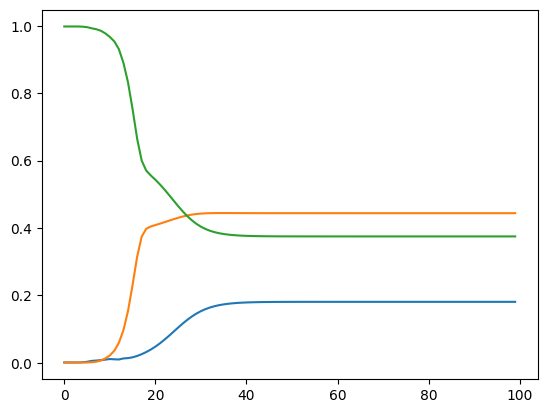

In [38]:
class Daisyworld:
  def __init__(self, b_daisy, w_daisy, p=1.0):
    '''initialize a Daisyworld object, in preparation for a simulation
    b_daisy : Daisy, choose the object you want to be the black daisies
    w_daisy : Daisy, choose the object you want to be the black daisies
    p : float, amount of fertile ground on planet, designed to be left at 1.0 (100%), but can be changed if desired'''
    self.black = b_daisy #the black daisy used in the simulation, designed to be a daisy class object
    self.white = w_daisy #the white daisy used in the simulation, also designed to be a daisy class object
    self.p = p #the total planet percentage as a decimal, designed to be 1.0, but could in theory be lowered
    self.x = self.p - self.black.pop - self.white.pop #total planet remaining for expansion, utilized in calculations of growth
    self.luminosity = 0.5 #initial value of luminosity, which will then increase each step by (0.02*)
    self.sol_constant = 917
    self.stefboltz = 5.67*(10**-8)
    self.q = 0.2*(self.sol_constant/self.stefboltz)
    self.cycle_num = 0
  
  def dw_temp(self):
    '''calculates the temperature for the year on Daisyworld
    daisyworldtemp = ((solar_flux*(1-planetary_albedo)/stefboltz)^(0.25))-273'''
    temp = (((self.luminosity * self.sol_constant)*(1-self.dw_albedo())/self.stefboltz)**(0.25))-273
    return temp

  def dw_albedo(self):
    '''calculates the albedo (reflective quantity as a decimal/fraction) of the entire planet
    planetary_albedo = (white_daisies*WD_albedo)+(black_daisies*BD_albedo)+(X*bare_ground_albedo(=0.5))'''
    planet_albedo = (self.white.pop * self.white.albedo) + (self.black.pop * self.black.albedo) + (self.x*0.5)
    return planet_albedo

  def daisy_temp(self, daisy):
    '''Calculate the temperature of one of either black or white daisies in a daisyworld simulation
    D_temp = ((q*(planetary_albedo-D_albedo)+((daisyworld__temp+273)^4))^(0.25))-273'''
    d_temp = ((self.q*(self.dw_albedo()-daisy.albedo)+((self.dw_temp()+273)**4))**0.25)-273
    return d_temp

  def ground_temp(self):
    '''ground temperature = ((q*(planetary_albedo - bare_ground_albedo) + ((daisyworld__temp + 273)^4))^(0.25))-273'''
    g_temp = ((self.q*(self.dw_albedo-0.5) + ((self.dw_temp()+273)**4))**(0.25))-273
    return g_temp

  def step(self):
    '''Advances the simulation one timestep'''
    planet_temp = self.dw_temp()
    bd_temp = self.daisy_temp(self.black)
    wd_temp = self.daisy_temp(self.white)
    self.black.pop = self.black.pop + (self.black.growth_rate(bd_temp)*self.x)-self.black.death_rate() #calculates the population of black daisies
    self.white.pop = self.white.pop + (self.white.growth_rate(wd_temp)*self.x)-self.white.death_rate() #calculates the population of black daisies
    self.x = self.p - self.black.pop - self.white.pop
    planet_albedo = self.dw_albedo()
    self.cycle_num += 1
    self.luminosity += (0.02*self.cycle_num) if self.luminosity < 1 else 0


world = Daisyworld(black, white)
frames = 100
b_daisypop = []
w_daisypop = []
x_remaining = []
for i in range(frames):
  world.step()
  b_daisypop.append(world.black.pop)
  w_daisypop.append(world.white.pop)
  x_remaining.append(world.x)
plt.plot(range(frames), b_daisypop)
plt.plot(range(frames), w_daisypop)
plt.plot(range(frames), x_remaining)
plt.show()